In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
%run 01_LLMs_konfigurieren.ipynb

In [3]:
%run 02_Daten_laden.ipynb

In [6]:
# Bilde ein Subset mit 1.000 Einträgen
sst2_subset = sst2_combined[:1000]
sst2_subset

,index,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...,...
995,995,you wish you were at home watching that movie ...,0
996,996,'s no point in extracting the bare bones of by...,0
997,997,underdeveloped,0
998,998,the jokes are flat,0


In [6]:
sb10k_subset = sb10k_combined[:1000]
sb10k_subset

,index,Text,Sentiment,sentiment_coded
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,positive,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",neutral,2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,neutral,2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,neutral,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,neutral,2
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,positive,1
996,996,Cros Kindermusik braucht keiner .,negative,0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,positive,1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,positive,1


# Chain of thought

## OpenAI / GPT

In [15]:
openai_client

### SST2

In [7]:
from pydantic import BaseModel

class Step(BaseModel):
    explanation: str
    output: str

class CoT(BaseModel):
    steps: list[Step]
    final_answer: str

In [17]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Anmerkung: Im ersten Lauf wurde nur das erste Exemplar verwendet (besseres Ergebnis!) Im zweiten Lauf wie hier zu sehen 4 Exemplars
system_prompt = """You classify sentiments of a text. Final_answer should be ONLY negative or positive!
### EXAMPLES ###
Q: Classify the following text into one of these two sentiments ['negative', 'positive']. 
    Text: "The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work."
A: The sentence “The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work” can be classified as negative because several factors point to disappointment and deficiencies. 
    First, the film’s low to mid-range budget is mentioned, which might seem neutral or slightly negative at first. 
    However, the phrase “betrayed by” indicates an unexpected weakness, suggesting that a particular aspect highlights the film’s lower quality. 
    The term “surprisingly shoddy makeup work” is described as especially disappointing. The word “shoddy” means substandard or poorly done, and the fact that this is “surprisingly” bad suggests that better quality was expected. 
    This combination of unmet expectations and the emphasis on a negative aspect leads to an overall negative judgment.      

Q: Classify the following text into one of these two sentiments ['negative', 'positive']. 
    Text: "look smeary and blurry , to the point of distraction."
A: The phrase “look smeary and blurry, to the point of distraction” conveys a negative sentiment due to several factors:
    First, the words “smeary” and “blurry” describe visual qualities that are generally undesirable, particularly if clarity is expected. “Smeary” suggests a smudged or unclear appearance, which implies poor quality. Similarly, “blurry” is associated with an out-of-focus or indistinct view, which further emphasizes an unsatisfactory experience.
    Moreover, the phrase “to the point of distraction” indicates that the smeary and blurry appearance is so pronounced that it actively interferes with the viewer’s ability to focus or engage. This intensifies the negative impression by highlighting that the issue is not minor but significant enough to disrupt the experience.
    In sum, the negative sentiment arises from both the use of unappealing descriptors like “smeary” and “blurry” and the emphasis on how these flaws make the experience distracting, suggesting a notably poor quality.

Q: Classify the following text into one of these two sentiments ['negative', 'positive']. 
    Text: "have a passion for the material"
A:  The phrase “have a passion for the material” conveys a positive sentiment due to several factors.
    First, the word “passion” inherently implies strong enthusiasm, dedication, and excitement. When someone has a passion for something, they are deeply invested and genuinely interested, which is generally seen as a positive trait, especially in contexts like learning, teaching, or creative work.
    Furthermore, the phrase “for the material” suggests that this enthusiasm is directed toward specific content or subject matter. This implies an eagerness to engage deeply with the topic, which can lead to positive outcomes like improved understanding, motivation, or the ability to inspire others.
    In summary, the positive sentiment stems from the concept of “passion,” which reflects a strong, positive engagement, and “for the material,” which implies a meaningful, enthusiastic connection with a particular subject.

Q: Classify the following text into one of these two sentiments ['negative', 'positive']. 
    Text: "it sets out with no pretensions and delivers big time"
A: The sentence “it sets out with no pretensions and delivers big time” conveys a positive sentiment due to several factors:
    First, the phrase “sets out with no pretensions” suggests an honest, straightforward approach. The subject is presented as unassuming and without arrogance, which can be appealing because it implies authenticity and modesty. This setup generally creates an expectation of humility or simplicity in the delivery.
    Then, the phrase “delivers big time” contrasts effectively with the initial modesty. The expression “delivers big time” implies a successful, impactful result that surpasses expectations. It suggests that, despite the lack of grand promises, the subject has achieved something substantial and impressive, which is framed positively.
    In sum, the positive sentiment stems from the combination of modesty (“no pretensions”) with impressive achievement (“delivers big time”), highlighting a surprising and commendable success.

""" 

user_prompt = ("""Classify the following text into one of these two sentiments ['negative', 'positive']""")

# Schleife mit API-Call
for index, row in sst2_subset.iterrows():
    text = row['sentence']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse( 
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                { 
                "role": "system", 
                "content": system_prompt
                    
                },
                {
                "role": "user",
                 "content": (user_prompt + f"Text: {text}:")
                }
            ],
            temperature = 0.2,
            response_format=CoT
        )
        response_content = response.choices[0].message.parsed #response.choices[0].message.content
        result_step = response_content.steps
        final_answer = response_content.final_answer
        print(index, " ", "Label: ",final_answer )        
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_df.loc[row_counter] = [index, text, result_step, final_answer] # [index, text, steps, response_content]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")




0   Label:  negative
1   Label:  negative
2   Label:  positive
3   Label:  positive
4   Label:  negative
5   Label:  negative
6   Label:  positive
7   Label:  negative
8   Label:  negative
9   Label:  positive
10   Label:  negative
11   Label:  negative
12   Label:  negative
13   Label:  negative
14   Label:  negative
15   Label:  positive
16   Label:  negative
17   Label:  positive
18   Label:  negative
19   Label:  positive
20   Label:  positive
21   Label:  negative
22   Label:  positive
23   Label:  positive
24   Label:  negative
25   Label:  positive
26   Label:  negative
27   Label:  negative
28   Label:  positive
29   Label:  negative
30   Label:  negative
31   Label:  positive
32   Label:  negative
33   Label:  negative
34   Label:  negative
35   Label:  negative
36   Label:  negative
37   Label:  positive
38   Label:  negative
39   Label:  ambiguous
40   Label:  negative
41   Label:  negative
42   Label:  negative
43   Label:  positive
44   Label:  ambiguous
45   Label:  posit

In [18]:
results_gpt_df

,index,sentence,steps,generated_label
0,0,hide new secretions from the parental units,"[explanation='The phrase ""hide new secretions ...",negative
1,1,"contains no wit , only labored gags","[explanation='The phrase ""contains no wit"" ind...",negative
2,2,that loves its characters and communicates som...,"[explanation='The phrase ""loves its characters...",positive
3,3,remains utterly satisfied to remain the same t...,"[explanation='The phrase ""remains utterly sati...",positive
4,4,on the worst revenge-of-the-nerds clichés the ...,"[explanation='The phrase ""on the worst revenge...",negative
...,...,...,...,...
995,995,you wish you were at home watching that movie ...,"[explanation='The phrase ""you wish you were at...",negative
996,996,'s no point in extracting the bare bones of by...,"[explanation='The phrase ""there\'s no point in...",negative
997,997,underdeveloped,"[explanation='The term ""underdeveloped"" typica...",negative
998,998,the jokes are flat,"[explanation='The phrase ""the jokes are flat"" ...",negative


In [19]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_final = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].replace({'negative': 0, 'positive': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final_ver = results_gpt_df_final[results_gpt_df_final['generated_label'].isin([0, 1])]

# als int formatieren
results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_50512/829187267.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)


In [20]:

# CSV abspeichern 
results_gpt_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SST2_CoT3syst_GPT.csv')


### Evaluation

In [21]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sst2_subset, results_gpt_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.86
Precision: 0.99
Recall: 0.75
F1-Score: 0.86
Confusion Matrix:
[[453   3]
 [131 399]]


### SB10k

In [ ]:
Du klassifizierst die Sentiments eines Textes. Verwende 0 für negativ, 1 für positiv und 2 für neutral.
Beispiel:
Eingabe: Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: 
Text: ‘@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?’
Ausgabe: Der Satz „@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?“ wird als neutral bewertet, 
da er keine emotionalen oder wertenden Elemente enthält. 
Zunächst handelt es sich um eine sachliche Anrede mit „@danieleicher“, die lediglich den Gesprächspartner adressiert. 
Die darauf folgende Bitte „PIN bitte per DM“ ist ebenfalls rein funktional formuliert, ohne positive oder negative Emotionen auszudrücken. 
Der zweite Teil des Satzes, „welches Modell soll ich Dir kaufen?“, ist eine einfache Frage, die nach einer Präferenz fragt, ohne eine Wertung oder Gefühlsregung zu implizieren. 
Insgesamt bleibt der Ton des Textes informativ und neutral, ohne erkennbare positive oder negative Konnotationen.
Response: neutral

In [24]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_sb10k_df = pd.DataFrame(columns=['index', 'sentence', 'steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sb10k_subset.iterrows():
    text = row['Text']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse( # .chat.completions.create(
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                { # Return only 0 or 1 without additional text. Use 0 for negative and 1 for positive Sentiments.
                "role": "system", 
                "content": """"Du klassifizierst die Sentiments eines Textes. Verwende 0 für negativ, 1 für positiv und 2 für neutral.
                Beispiel:
                    Eingabe: Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: 
                            Text: ‘@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?’
                    Ausgabe: Der Satz „@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?“ wird als neutral bewertet, 
                    da er keine emotionalen oder wertenden Elemente enthält. 
                    Zunächst handelt es sich um eine sachliche Anrede mit „@danieleicher“, die lediglich den Gesprächspartner adressiert. 
                    Die darauf folgende Bitte „PIN bitte per DM“ ist ebenfalls rein funktional formuliert, ohne positive oder negative Emotionen auszudrücken. 
                    Der zweite Teil des Satzes, „welches Modell soll ich Dir kaufen?“, ist eine einfache Frage, die nach einer Präferenz fragt, ohne eine Wertung oder Gefühlsregung zu implizieren. 
                    Insgesamt bleibt der Ton des Textes informativ und neutral, ohne erkennbare positive oder negative Konnotationen.
                    Response: neutral
                 """
                },
                {
                "role": "user",
                 "content": (f"""Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: 
                                 Text: {text} """)
                }
            ],
            temperature = 0.2,
            response_format=CoT
        )
        response_content = response.choices[0].message.parsed #response.choices[0].message.content
        result_step = response_content.steps
        final_answer = response_content.final_answer
        print(index, " ", "Label: ",final_answer )          
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_sb10k_df.loc[row_counter] = [index, text, result_step, final_answer]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0   Label:  positiv
1   Label:  neutral
2   Label:  negativ
3   Label:  neutral
4   Label:  neutral
5   Label:  neutral
6   Label:  positiv
7   Label:  negativ
8   Label:  neutral
9   Label:  positiv
10   Label:  neutral
11   Label:  neutral
12   Label:  neutral
13   Label:  neutral
14   Label:  positiv
15   Label:  negativ
16   Label:  neutral
17   Label:  neutral
18   Label:  neutral
19   Label:  positiv
20   Label:  neutral
21   Label:  neutral
22   Label:  positiv
23   Label:  positiv
24   Label:  neutral
25   Label:  neutral
26   Label:  neutral
27   Label:  neutral
28   Label:  neutral
29   Label:  neutral
30   Label:  neutral
31   Label:  neutral
32   Label:  neutral
33   Label:  positiv
34   Label:  neutral
35   Label:  neutral
36   Label:  negativ
37   Label:  negativ
38   Label:  neutral
39   Label:  neutral
40   Label:  negativ
41   Label:  neutral
42   Label:  negativ
43   Label:  neutral
44   Label:  neutral
45   Label:  positiv
46   Label:  neutral
47   Label:  positiv
48

In [25]:
results_gpt_sb10k_df

,index,sentence,steps,generated_label
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,[explanation='Der Text spricht über einen Hear...,positiv
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...","[explanation='Der Text enthält den Titel ""Tain...",neutral
2,2,Aber wenigstens kommt #Supernatural heute mal ...,[explanation='Der Text spricht über die Sendun...,negativ
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,[explanation='Der Text beschreibt ein Angebot ...,neutral
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,[explanation='Der Text enthält eine Aufforderu...,neutral
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,"[explanation='Der Text erwähnt ""Die Liebe unte...",positiv
996,996,Cros Kindermusik braucht keiner .,[explanation='Der Text drückt eine klare negat...,negativ
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,[explanation='Der Text berichtet über ein Spor...,positiv
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,[explanation='Der Text beginnt mit einer freun...,positiv


In [26]:
# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_sb10k_df['generated_label'] = results_gpt_sb10k_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_sb10k_df['generated_label'] = results_gpt_sb10k_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_sb10k_df_ver = results_gpt_sb10k_df # [results_gpt_sb10k_df['generated_label'].isin(['0', '1','2',0,1,2])]

# Mapping: 'negative', 'negativ' zu 0, 'positive', 'positiv' zu 1, 'neutral' zu 2
results_gpt_sb10k_df_ver['generated_label'] = results_gpt_sb10k_df_ver['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_sb10k_df_final = results_gpt_sb10k_df_ver[results_gpt_sb10k_df_ver['generated_label'].isin(['0', '1','2',0,1,2])]

# als int formatieren
results_gpt_sb10k_df_final['generated_label'] = results_gpt_sb10k_df_final['generated_label'].astype(int)


/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_50512/3416653972.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gpt_sb10k_df_ver['generated_label'] = results_gpt_sb10k_df_ver['generated_label'].replace({


In [27]:
results_gpt_sb10k_df_final

,index,sentence,steps,generated_label
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,[explanation='Der Text spricht über einen Hear...,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...","[explanation='Der Text enthält den Titel ""Tain...",2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,[explanation='Der Text spricht über die Sendun...,0
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,[explanation='Der Text beschreibt ein Angebot ...,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,[explanation='Der Text enthält eine Aufforderu...,2
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,"[explanation='Der Text erwähnt ""Die Liebe unte...",1
996,996,Cros Kindermusik braucht keiner .,[explanation='Der Text drückt eine klare negat...,0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,[explanation='Der Text berichtet über ein Spor...,1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,[explanation='Der Text beginnt mit einer freun...,1


In [28]:
# CSV abspeichern 
results_gpt_sb10k_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SB10k_CoTexpFewShot_GPT.csv', encoding='utf-8-sig')


#### Evaluation

In [29]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sb10k_subset, results_gpt_sb10k_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.72
Precision (macro): 0.68
Recall (macro): 0.75
F1-Score (macro): 0.69
Confusion Matrix:
[[131   6  24]
 [ 22 177  35]
 [111  86 408]]


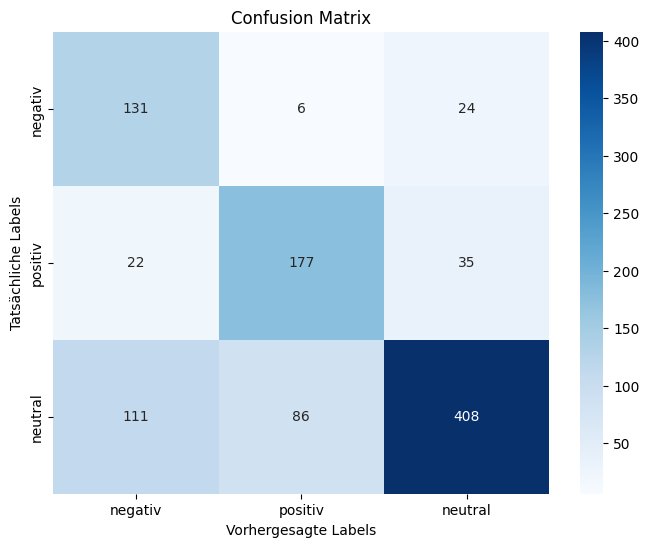

In [30]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

In [4]:
genai_model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash',
    generation_config={'temperature': 0.2},
    safety_settings={<HarmCategory.HARM_CATEGORY_HARASSMENT: 7>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_HATE_SPEECH: 8>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: 9>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: 10>: <HarmBlockThreshold.BLOCK_NONE: 4>},
    tools=None,
    system_instruction=None,
    cached_content=None
)

### SST2

In [16]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""
    You classify sentiments of a text. Think step-by-step and use this JSON Schema: Result = {'steps':str, 'final_answer': str}
    Example:
        Input: Classify the following text ONLY in one of these two sentiments ['negative', 'positive']. Text: "The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work."
        Answer: {'steps': "The sentence “The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work” can be classified as negative because several factors point to disappointment and deficiencies. 
                First, the film’s low to mid-range budget is mentioned, which might seem neutral or slightly negative at first. 
                However, the phrase “betrayed by” indicates an unexpected weakness, suggesting that a particular aspect highlights the film’s lower quality. 
                The term “surprisingly shoddy makeup work” is described as especially disappointing. The word “shoddy” means substandard or poorly done, and the fact that this is “surprisingly” bad suggests that better quality was expected. 
                This combination of unmet expectations and the emphasis on a negative aspect leads to an overall negative judgment.", 
                'final_answer': Negative
                 """,
    generation_config={"response_mime_type": "application/json"})


# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sst2_subset.iterrows():
    text = row['sentence']

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"""Classify the following text ONLY in one of these two sentiments 
                                                ['negative', 'positive']. Text: {text}.""")
        llm_output = response.text
        #print(llm_output)
        
        # dict speichern
        resp_dict = json.loads(llm_output)
        #print(resp_dict)

        # durch dict iterieren
        steps = resp_dict['steps']
        final_result = resp_dict['final_answer']
        
        print(index, " ", "output:  ", final_result)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, steps, final_result]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0   output:   negative
1   output:   negative
2   output:   positive
3   output:   positive
4   output:   negative
5   output:   negative
6   output:   positive
7   output:   neutral
8   output:   negative
9   output:   positive
10   output:   negative
11   output:   negative
12   output:   neutral
13   output:   negative
14   output:   negative
15   output:   positive
16   output:   negative
17   output:   positive
18   output:   negative
19   output:   positive
20   output:   positive
21   output:   positive
22   output:   positive
23   output:   positive
24   output:   negative
25   output:   positive
26   output:   negative
27   output:   Neutral
28   output:   positive
29   output:   negative
30   output:   negative
31   output:   positive
32   output:   negative
33   output:   negative
34   output:   Neutral
35   output:   positive
36   output:   positive
37   output:   positive
38   output:   negative
39   output:   neutral
40   output:   positive
41   output:   negative
42   ou

In [18]:
results_gemini_df

,index,sentence,steps,generated_label
0,0,hide new secretions from the parental units,"The phrase ""hide new secretions from the paren...",negative
1,1,"contains no wit , only labored gags","The statement ""contains no wit, only labored g...",negative
2,2,that loves its characters and communicates som...,"The text ""that loves its characters and commun...",positive
3,3,remains utterly satisfied to remain the same t...,"The statement ""remains utterly satisfied to re...",positive
4,4,on the worst revenge-of-the-nerds clichés the ...,"The phrase ""on the worst revenge-of-the-nerds ...",negative
...,...,...,...,...
995,995,you wish you were at home watching that movie ...,"The statement ""you wish you were at home watch...",negative
996,996,'s no point in extracting the bare bones of by...,"The sentence ""s no point in extracting the bar...",negative
997,997,underdeveloped,"The single word ""underdeveloped"" inherently ca...",negative
998,998,the jokes are flat,"The statement ""the jokes are flat"" expresses a...",negative


In [22]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({'negative': 0, 'positive': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_99675/3204135013.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)


In [21]:

# CSV abspeichern 
results_gemini_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SST2_CoT_GEMINI.csv', encoding='utf-8-sig')


#### Evaluation

In [24]:
results_gemini_df_final

,index,sentence,steps,generated_label
0,0,hide new secretions from the parental units,"The phrase ""hide new secretions from the paren...",0
1,1,"contains no wit , only labored gags","The statement ""contains no wit, only labored g...",0
2,2,that loves its characters and communicates som...,"The text ""that loves its characters and commun...",1
3,3,remains utterly satisfied to remain the same t...,"The statement ""remains utterly satisfied to re...",1
4,4,on the worst revenge-of-the-nerds clichés the ...,"The phrase ""on the worst revenge-of-the-nerds ...",0
...,...,...,...,...
995,995,you wish you were at home watching that movie ...,"The statement ""you wish you were at home watch...",0
996,996,'s no point in extracting the bare bones of by...,"The sentence ""s no point in extracting the bar...",0
997,997,underdeveloped,"The single word ""underdeveloped"" inherently ca...",0
998,998,the jokes are flat,"The statement ""the jokes are flat"" expresses a...",0


In [25]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sst2_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.95
Precision: 0.98
Recall: 0.92
F1-Score: 0.95
Confusion Matrix:
[[415  10]
 [ 37 424]]


### SB10k

In [23]:
# system-prompt gemini

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  safety_settings='BLOCK_NONE',

  system_instruction=
    """
            Du klassifizierst die Sentiments eines Textes. Denke Schritt für Schritt und verwende dieses JSON Schema: Result = {'steps':str, 'final_answer': str}
            Beispiel:
            Eingabe: Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: 
                    Text: ‘@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?’
            Antwort: 
            {'steps': "Der Satz „@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?“ wird als neutral bewertet, 
            da er keine emotionalen oder wertenden Elemente enthält. 
            Zunächst handelt es sich um eine sachliche Anrede mit „@danieleicher“, die lediglich den Gesprächspartner adressiert. 
            Die darauf folgende Bitte „PIN bitte per DM“ ist ebenfalls rein funktional formuliert, ohne positive oder negative Emotionen auszudrücken. 
            Der zweite Teil des Satzes, „welches Modell soll ich Dir kaufen?“, ist eine einfache Frage, die nach einer Präferenz fragt, ohne eine Wertung oder Gefühlsregung zu implizieren. 
            Insgesamt bleibt der Ton des Textes informativ und neutral, ohne erkennbare positive oder negative Konnotationen.",
            'final_answer: 2'}
    """,
  generation_config={"response_mime_type": "application/json"}
    )

# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sb10k_subset.iterrows():
    text = row['Text']

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"""Du klassifizierst die Sentiments eines Textes. 
                                                Denke Schritt-für-Schritt.
                                                Text: {text}""")
        llm_output = response.text
        #print(llm_output)
        
        # dict speichern
        resp_dict = json.loads(llm_output)
        #print(resp_dict)

        # durch dict iterieren
        steps = resp_dict['steps']
        final_result = resp_dict['final_answer']
        
        print(index, " ", "output:  ", final_result)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, steps, final_result]
        row_counter += 1
    
    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0   2

1   2

2   0 

3   2

4   0 

5   2

6   1 

7   0 

8   2

9   1

10   1

11   2

12   2

13   2

14   1

15   0 

16   0

17   2

18   2

19   1

20   0 

21   2

22   1

23   1

24   2

25   2

26   2

27   2

28   0

29   2

30   2

31   0 

32   0

33   1

34   2

35   2

36   0

37   2

38   2

39   2

40   0 

41   2 

42   0 

43   2

44   1

45   1

46   2

47   1

48   0 

49   0 

50   2

51   0

52   1

53   0 

54   0

55   0 

56   1

57   1

58   0 

59   2

60   2 

61   2

62   2 

63   2 

64   2

65   2 

66   1

67   1

68   1

69   2

70   0 

71   2

72   0

73   1

74   0 

75   1

76   1

77   2

78   2

79   2

80   1

81   2

82   1

83   0

84   2

85   1

86   0 

87   2

88   0 

89   1

90   2

91   1

92   2 

93   0 

94   1

95   1

96   2

97   0

98   0 

99   2

100   1

101   0 

102   1

103   2

104   2

105   0 

106   0 

107   2

108   2

109   1

110   1

111   2

112   2

113   0 

114   0 

115   1

116   2

117   1

Fehler bei der Ve

In [ ]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1, 2])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




In [24]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SB10k_CoT_GEMINI.csv', encoding='utf-8-sig')



#### Evaluation

In [25]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sb10k_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.60
Precision (macro): 0.60
Recall (macro): 0.68
F1-Score (macro): 0.59
Confusion Matrix:
[[137   4  13]
 [ 25 151  54]
 [190 105 300]]


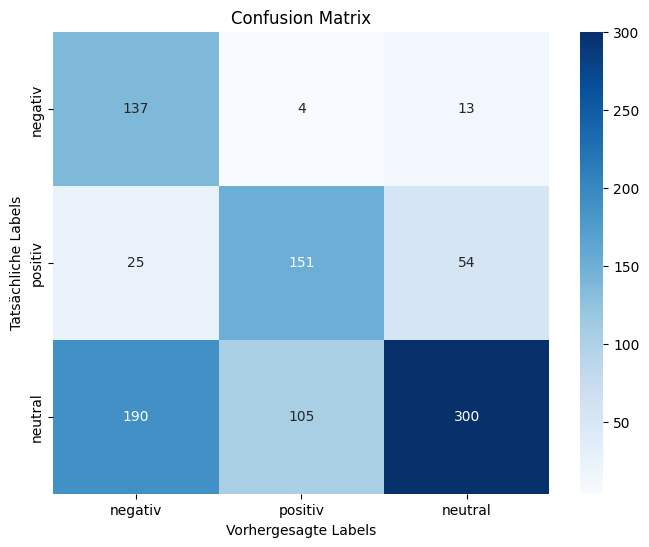

In [26]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()